# Auto Insurance fall 2017 
29/06/2022

By: Monica AQUINO 

## Objective: 

    The code should be able to make a prediction on the dataset Auto Insurance based on the Kaggle competition. For each ID in the test set, you must predict a probability for the TARGET variable (TARGET_FLAG)



## Input:  

    test_auto.csv 

    train_auto.csv

##  Output: 

    prediction.csv 



More information about this test in:  
https://www.kaggle.com/c/auto-insurance-fall-2017

https://github.com/descartes-underwriting/data-scientist-technical-test



#     Data loading and analysis
Files provided: test_auto.csv 
and train_auto.csv


In [238]:
#Import modules 
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier




Train Data Shape: (8161, 26)
Test Data Shape: (2141, 26)


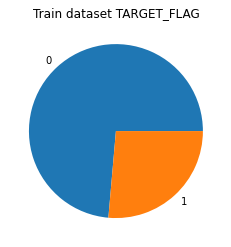

In [173]:
# Load the data
train_data = pd.read_csv('train_auto.csv')
test_data  = pd.read_csv('test_auto.csv')

#Plot values of prediction target 
fig00, ax00= plt.subplots(nrows=1, ncols=1)

ax00.pie(train_data['TARGET_FLAG'].value_counts(), labels=[0,1])
ax00.set_title('Train dataset TARGET_FLAG')


# Print shape of datasets
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)


In [174]:
print('Distribution is:')
print('Train_dataset 1:',round(100*train_data['TARGET_FLAG'].sum()/len(train_data),2), '    0: ',100-round(100*train_data['TARGET_FLAG'].sum()/len(train_data),2))
print(train_data['TARGET_FLAG'].sum())

Distribution is:
Train_dataset 1: 26.38     0:  73.62
2153


At first instance from plot, the problem is not balanced. Train dataset has 5161 samples, and test dataset 2141 samples. The distribution of test dataset is 26pct of positive class vs 74pct of negative class i.e.  it is an imbalanced binary classification problem. 

In [175]:
 train_data.describe()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,5151.867663,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,33.485725,5.351305,0.798554,1.695503,8.328323
std,2978.893962,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,15.908333,4.146635,1.158453,2.147112,5.700742
min,1.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,2559.000000,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,5133.000000,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,7745.000000,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,10302.000000,1.000000,107586.136160,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000


In [176]:
test_data.describe()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,2141.000000,0.0,0.0,2141.000000,2140.000000,2141.000000,2047.000000,2141.000000,2141.000000,2141.000000,2141.000000,2012.000000
mean,5150.098552,NaN,NaN,0.162541,45.016822,0.717422,10.379091,33.152265,5.244745,0.808968,1.765997,8.183400
std,2956.329272,NaN,NaN,0.486949,8.525006,1.116579,4.170008,15.722393,3.971026,1.137481,2.203413,5.766263
min,3.000000,NaN,NaN,0.000000,17.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000
25%,2632.000000,NaN,NaN,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,5224.000000,NaN,NaN,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,7669.000000,NaN,NaN,0.000000,51.000000,1.000000,13.000000,43.000000,7.000000,2.000000,3.000000,12.000000
max,10300.000000,NaN,NaN,3.000000,73.000000,5.000000,19.000000,105.000000,25.000000,5.000000,12.000000,26.000000


Features, `INCOME`,`HOME_VAL`,`BLUEBOOK`,`OLDCLAIM` should be numerical, remove the dollar sign. Replace negative value observed at `CAR_AGE`

In [177]:
#Replace dollar sign
dollars_columns = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
train_data[dollars_columns] = train_data[dollars_columns].replace('[\$,]', '', regex=True).astype(float)
test_data[dollars_columns] = test_data[dollars_columns].replace('[\$,]', '', regex=True).astype(float)

#Update age negative values
train_data.CAR_AGE = train_data.CAR_AGE.apply(lambda x: 0 if x < 0 else x)
test_data.CAR_AGE = test_data.CAR_AGE.apply(lambda x: 0 if x < 0 else x)


In [178]:
#Define Features types: 
#Categorical, numerical?
print(train_data.dtypes)
nums_cols = list(train_data.select_dtypes(include=['int64', 'float64']).columns)
cats_cols = list(train_data.select_dtypes(include=['object']).columns)


INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME         float64
PARENT1         object
HOME_VAL       float64
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK       float64
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM       float64
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object


## Plot Categorical Features 

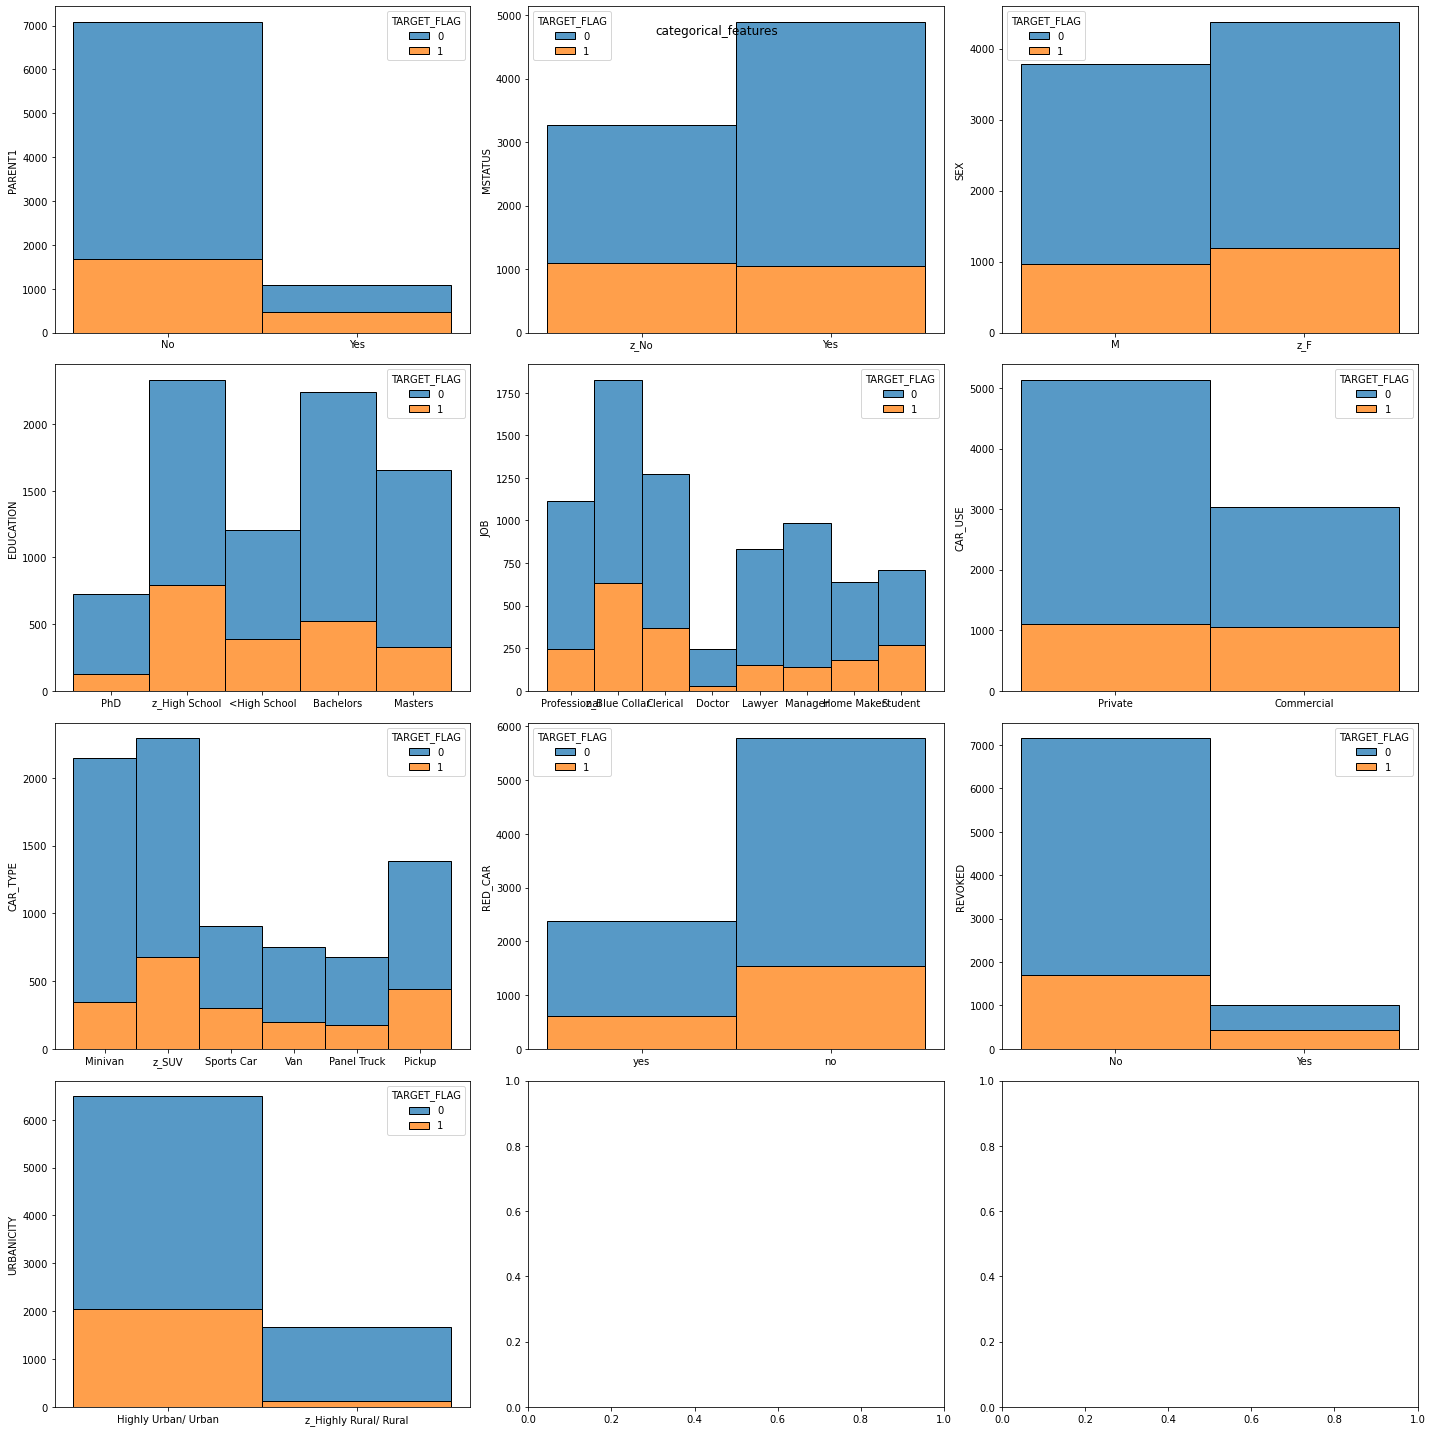

In [112]:
#plot CATEGORICAL features 
fig0, axes0 = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes0 = axes0.ravel()

for idx0 in range(0,len(cats_cols)):
    col=cats_cols[idx0]
    #sns.countplot(x=col, data=train_data, ax=axes0[idx])
    sns.histplot(data=train_data, x=col, hue="TARGET_FLAG", multiple="stack",ax=axes0[idx0])
    axes0[idx0].set_xlabel('')
    axes0[idx0].set_ylabel(col)
fig0.suptitle('categorical_features')
fig0.tight_layout()
#fig0.savefig('categorical_features.png')


## Observations from CATEGORICAL features: 
    -Almost 50pct of revoked licenses costumers crashed

    -High school custumers have the highest ratio of crashing (30pct) among 4 education types 

    -Commercial cars have higher crash rate (34pct) compared to private (21pct)

    -Rural areas have almost a nule crash rate (6pct) compared to urban (31pct)


In [179]:
print(train_data[["REVOKED", "TARGET_FLAG"]].groupby(['REVOKED'], as_index=False).mean().sort_values(by='TARGET_FLAG', ascending=False),'\n')
print(train_data[["EDUCATION", "TARGET_FLAG"]].groupby(['EDUCATION'], as_index=False).mean().sort_values(by='TARGET_FLAG', ascending=False),'\n')
print(train_data[["CAR_USE", "TARGET_FLAG"]].groupby(['CAR_USE'], as_index=False).mean().sort_values(by='TARGET_FLAG', ascending=False),'\n')
print(train_data[["URBANICITY", "TARGET_FLAG"]].groupby(['URBANICITY'], as_index=False).mean().sort_values(by='TARGET_FLAG', ascending=False),'\n')
print(train_data[["JOB", "TARGET_FLAG"]].groupby(['JOB'], as_index=False).mean().sort_values(by='TARGET_FLAG', ascending=False),'\n')


  REVOKED  TARGET_FLAG
1     Yes     0.443000
0      No     0.238793 

       EDUCATION  TARGET_FLAG
4  z_High School     0.340343
0   <High School     0.320033
1      Bachelors     0.233274
2        Masters     0.197226
3            PhD     0.171703 

      CAR_USE  TARGET_FLAG
0  Commercial     0.345659
1     Private     0.215511 

              URBANICITY  TARGET_FLAG
0    Highly Urban/ Urban     0.313925
1  z_Highly Rural/ Rural     0.068904 

             JOB  TARGET_FLAG
6        Student     0.373596
7  z_Blue Collar     0.347397
0       Clerical     0.291896
2     Home Maker     0.280811
5   Professional     0.221128
3         Lawyer     0.183234
4        Manager     0.138664
1         Doctor     0.117886 



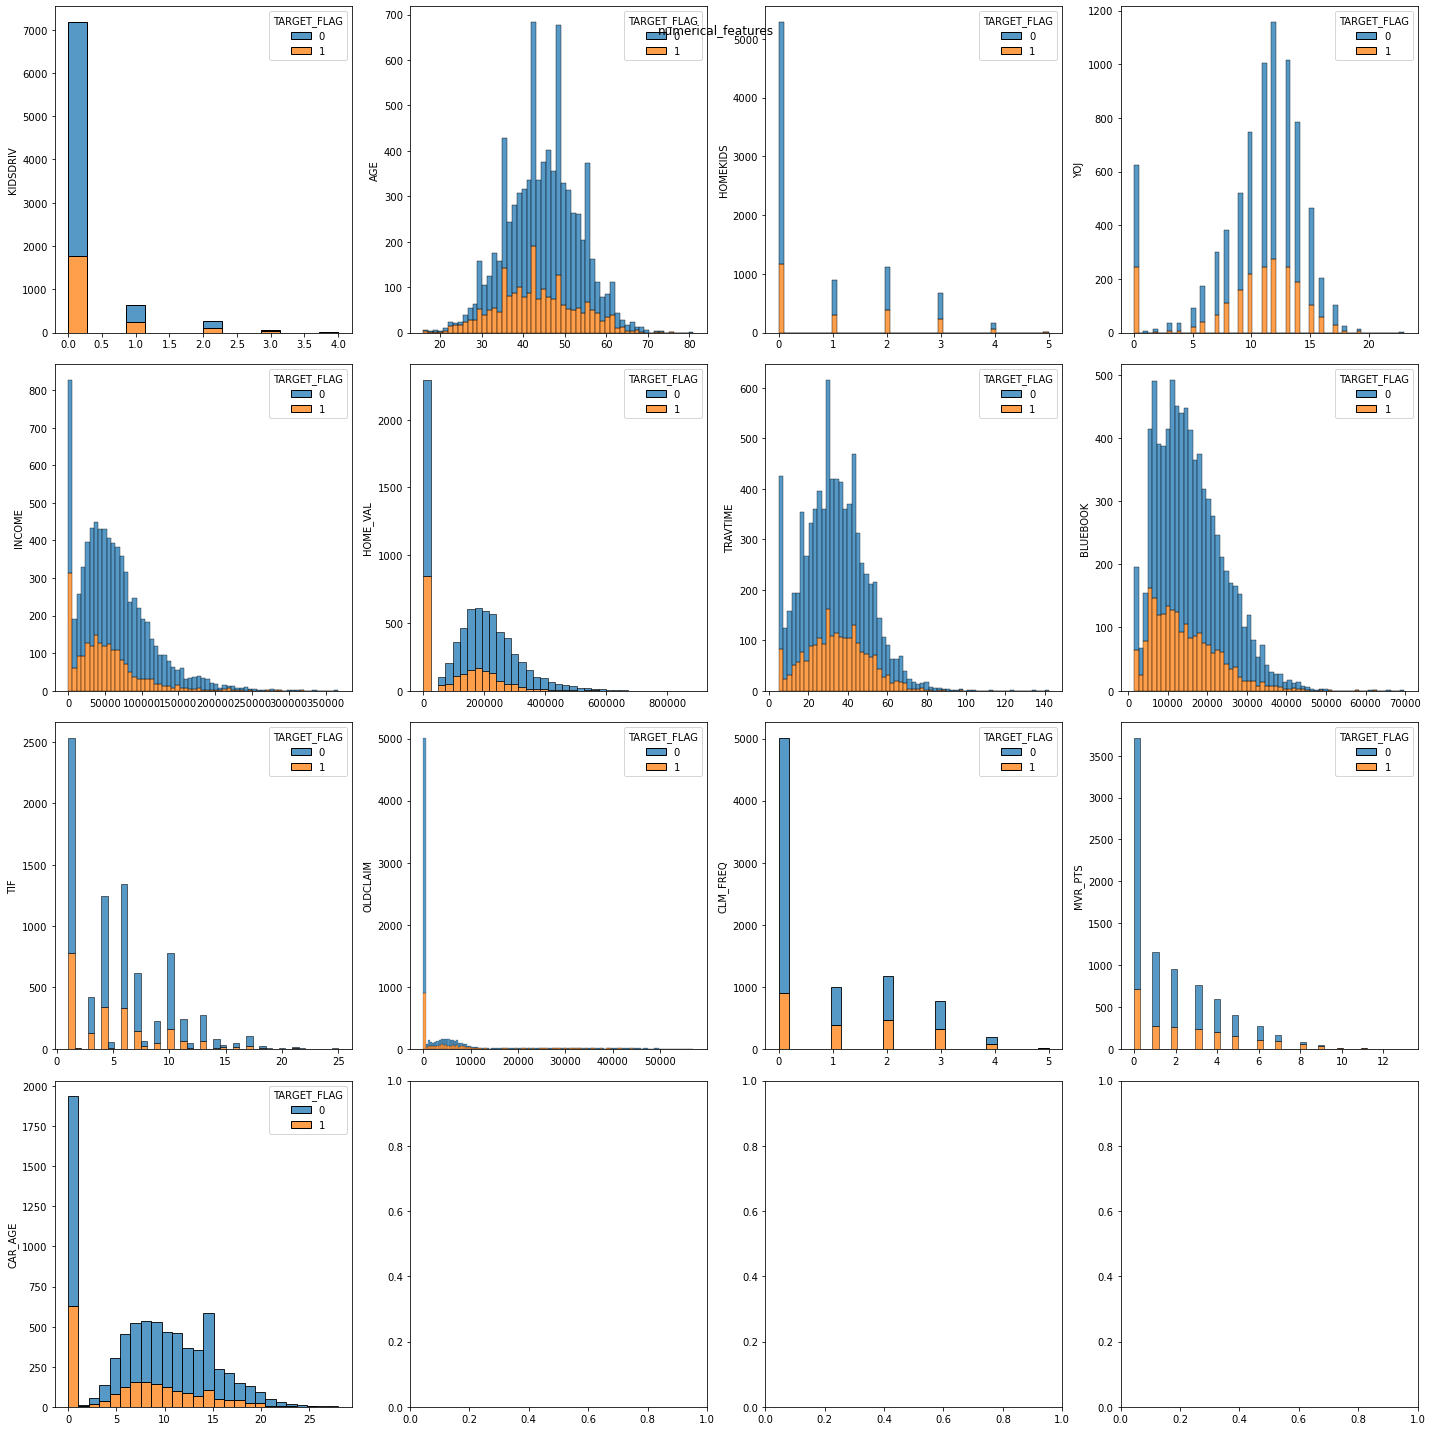

In [114]:

#plot NUMERICAL features 
fig1, axes1 = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes1 = axes1.ravel()
for idx1 in range(0,len(nums_cols[3::])):
 col=nums_cols[idx1+3]   
 sns.histplot(data=train_data, x=col, hue="TARGET_FLAG", multiple="stack",ax=axes1[idx1])
 axes1[idx1].set_xlabel('')
 axes1[idx1].set_ylabel(col)
 
fig1.suptitle('numerical_features')
fig1.tight_layout()
#fig1.savefig('numerical_features.png')


## Observations from NUMERICAL features: 

-`CLM_FREQ` is a highly indicator of crash rate, costumers with 0 previous claims are the least likely to crash, while custumers with the most claims have 40 pct crash rate 


In [180]:
print(train_data[["CLM_FREQ", "TARGET_FLAG"]].groupby(['CLM_FREQ'], as_index=False).mean().sort_values(by='TARGET_FLAG', ascending=False))

   CLM_FREQ  TARGET_FLAG
4         4     0.421053
3         3     0.404639
2         2     0.400512
5         5     0.388889
1         1     0.386158
0         0     0.179277


In [181]:
# Print missing values of datasets
null_values = train_data.isnull().sum()
null_values = round((null_values/train_data.shape[0] * 100), 2)
print('Missing values before processing')
null_values.sort_values(ascending=False)


Missing values before processing


JOB            6.45
CAR_AGE        6.25
HOME_VAL       5.69
YOJ            5.56
INCOME         5.45
AGE            0.07
URBANICITY     0.00
SEX            0.00
TARGET_FLAG    0.00
TARGET_AMT     0.00
KIDSDRIV       0.00
HOMEKIDS       0.00
PARENT1        0.00
MSTATUS        0.00
EDUCATION      0.00
TRAVTIME       0.00
CAR_USE        0.00
BLUEBOOK       0.00
TIF            0.00
CAR_TYPE       0.00
RED_CAR        0.00
OLDCLAIM       0.00
CLM_FREQ       0.00
REVOKED        0.00
MVR_PTS        0.00
INDEX          0.00
dtype: float64

In [182]:
# NUMERICAL columns
for c in nums_cols:
    print(c)
    # Get the mean
    mean1 = train_data[c].mean()
    mean2 = test_data[c].mean()
    # replace the NaN by mean
    train_data[c].fillna(mean1, inplace=True)
    test_data[c].fillna(mean2, inplace=True)
#----------------------------------------

# CATEGORICAL columns
for c in cats_cols:
    # Get the most frequent value (mode)
    mode1 = train_data[c].value_counts().index[0]
    mode2 = test_data[c].value_counts().index[0]
    # replace the NaN by mode
    train_data[c].fillna(mode1, inplace=True)
    test_data[c].fillna(mode2, inplace=True)
#----------------------------------------

INDEX
TARGET_FLAG
TARGET_AMT
KIDSDRIV
AGE
HOMEKIDS
YOJ
INCOME
HOME_VAL
TRAVTIME
BLUEBOOK
TIF
OLDCLAIM
CLM_FREQ
MVR_PTS
CAR_AGE


In [183]:
# Print missing values of datasets
null_values = train_data.isnull().sum()
null_values = round((null_values/train_data.shape[0] * 100), 2)
print('Missing values after processing')
null_values.sort_values(ascending=False)


Missing values after processing


URBANICITY     0.0
CAR_AGE        0.0
TARGET_FLAG    0.0
TARGET_AMT     0.0
KIDSDRIV       0.0
AGE            0.0
HOMEKIDS       0.0
YOJ            0.0
INCOME         0.0
PARENT1        0.0
HOME_VAL       0.0
MSTATUS        0.0
SEX            0.0
EDUCATION      0.0
JOB            0.0
TRAVTIME       0.0
CAR_USE        0.0
BLUEBOOK       0.0
TIF            0.0
CAR_TYPE       0.0
RED_CAR        0.0
OLDCLAIM       0.0
CLM_FREQ       0.0
REVOKED        0.0
MVR_PTS        0.0
INDEX          0.0
dtype: float64

In [184]:
train_data.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.000000,67349.000000,No,0.0,...,14230.0,11,Minivan,yes,4461.0,2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.000000,91449.000000,No,257252.0,...,14940.0,1,Minivan,yes,0.0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.000000,16039.000000,No,124191.0,...,4010.0,4,z_SUV,no,38690.0,2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.000000,61898.094609,No,306251.0,...,15440.0,7,Minivan,yes,0.0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,10.499286,114986.000000,No,243925.0,...,18000.0,1,z_SUV,no,19217.0,2,Yes,3,17.0,Highly Urban/ Urban


In [185]:
print('categorical features: ', len(cats_cols) , cats_cols,'\n')
print('numerical features: ', len(nums_cols),  nums_cols ,'\n')

categorical features:  10 ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY'] 

numerical features:  16 ['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE'] 



Encode categorical features and normalize numerical features 

In [186]:
#Edit binary categorical features  (7)

cat_feat_le = {}                           # dictionary to store encoder for each categorical feature
for cat_feat in cats_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train_data[cat_feat])
    train_data[cat_feat] = le.transform(train_data[cat_feat])
    cat_feat_le[cat_feat] = le
    
for cat_feat in cats_cols:
    le = preprocessing.LabelEncoder()
    le.fit(test_data[cat_feat])
    test_data[cat_feat] = le.transform(test_data[cat_feat])
    cat_feat_le[cat_feat] = le

scaler = preprocessing.StandardScaler()
train_data[nums_cols[3::]] = scaler.fit_transform(train_data[nums_cols[3::]])
test_data[nums_cols[3::]] = scaler.fit_transform(test_data[nums_cols[3::]])



In [187]:
train_data.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,-0.334421,1.763669,-0.646120,1.259101e-01,1.178460e-01,0,-1.235073,...,-0.175776,1.362319,0,1,0.048302,1.037176,0,0.607596,1.752448,0
1,2,0,0.0,-0.334421,-0.207599,-0.646120,1.259101e-01,6.388764e-01,0,0.816522,...,-0.091445,-1.049422,0,1,-0.459982,-0.689370,0,-0.789715,-1.327972,0
2,4,0,0.0,-0.334421,-1.135255,0.249732,-1.255512e-01,-9.914517e-01,0,-0.244645,...,-1.389666,-0.325900,5,0,3.948331,1.037176,0,0.607596,0.302839,0
3,5,0,0.0,-0.334421,0.720057,-0.646120,8.802942e-01,1.573027e-16,0,1.207291,...,-0.032058,0.397623,0,1,-0.459982,-0.689370,0,-0.789715,-0.421966,0
4,6,0,0.0,-0.334421,0.604100,-0.646120,4.466851e-16,1.147735e+00,0,0.710239,...,0.272009,-1.049422,5,0,1.729590,1.037176,1,0.607596,1.571247,0


# Prepare train/test datasets 
Finally, prepare features and prediction targets datasets and split the train dataset in train and validation dataset

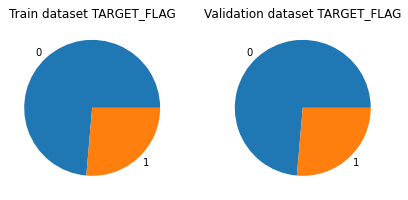

In [188]:
#Define features and prediction targets 
train_data = train_data.drop(columns=['INDEX'])
train_data = train_data.drop(columns=['TARGET_AMT'])
test_data = test_data.drop(columns=['INDEX'])
test_data = test_data.drop(columns=['TARGET_AMT'])

X_train = train_data.drop(columns=['TARGET_FLAG'])
y_train=train_data['TARGET_FLAG']
X_test = test_data.drop(columns=['TARGET_FLAG'])
y_test=test_data['TARGET_FLAG']


from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)



#Plot values of prediction target to double check distributions of TARGET_FLAG
fig00, ax00= plt.subplots(nrows=1, ncols=2)
ax00 = ax00.ravel()

ax00[0].pie(y_tr.value_counts(),labels=[0,1])
ax00[0].set_title('Train dataset TARGET_FLAG')

ax00[1].pie(y_val.value_counts(),labels=[0,1])
ax00[1].set_title('Validation dataset TARGET_FLAG')


plt.tight_layout()



# Prepare train/test datasets balanced


In [191]:
#Create balanced dataset for comparison

def balance_df(df,target):
### Separate the majority and minority classes
 df_minority  = df[df['TARGET_FLAG']==1]
 df_majority = df[df['TARGET_FLAG']==0]

### Now, downsamples majority labels equal to the number of samples in the minority class
 df_majority = df_majority.sample(len(df_minority), random_state=0)

### concat the majority and minority dataframes
 df = pd.concat([df_majority,df_minority])

## Shuffle the dataset to prevent the model from getting biased by similar samples
 df = df.sample(frac=1, random_state=0)
 return df 


train_data_u = balance_df(train_data,'TARGET_FLAG')


Distribution is:
Train_dataset 1: 50.0     0:  50.0
2153


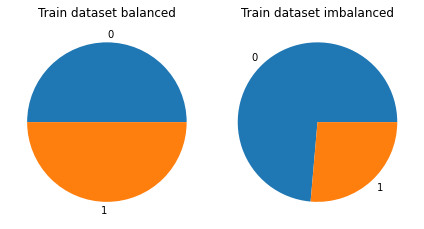

In [206]:
#Plot values of prediction target balanced 
fig00, ax00= plt.subplots(nrows=1, ncols=2)
ax00 = ax00.ravel()

ax00[0].pie(train_data_u['TARGET_FLAG'].value_counts(), labels=[0,1])
ax00[0].set_title('Train dataset balanced')

ax00[1].pie(train_data['TARGET_FLAG'].value_counts(), labels=[0,1])
ax00[1].set_title('Train dataset imbalanced')
plt.tight_layout()

print('Distribution is:')
print('Train_dataset 1:',round(100*train_data_u['TARGET_FLAG'].sum()/len(train_data_u),2), '    0: ',100-round(100*train_data_u['TARGET_FLAG'].sum()/len(train_data_u),2))
print(train_data_u['TARGET_FLAG'].sum())

In [207]:
#Split data imbalanced 
X_train_u = train_data_u.drop(columns=['TARGET_FLAG'])
y_train_u=train_data_u['TARGET_FLAG']
from sklearn.model_selection import train_test_split
X_tr_u, X_val_u, y_tr_u, y_val_u = train_test_split(X_train_u, y_train_u, test_size=0.2, random_state=42, stratify=y_train_u)


## Summary of Training datasets 

Two sets of train data were generated: 

    -Train imbalanced: train_data 
            -Train data: X_tr,y_tr   
            -Validation data: X_val, y_val
    -Train balanced: train_data_u
            -Train data: X_tr_u,y_tr_u  
            -Validation data: X_val_u, y_val_u

# Modeling 
    -Define a Model 
    -Fit a model 
    -Make prediction 
    -Validate model 
The train dataset is observed to be imbalanced, we compare metrics using imbalanced dataset and a balanced dataset. 

In [211]:
#Create funcions to print scores and model/fit/predict dataset  

def scores_toprint(y_val,y_val_pred):
    #Compute scores 
    acc_val = round(accuracy_score(y_val, y_val_pred),2)      # accuracy
    precision_val = round(precision_score(y_val, y_val_pred),2)     # precision
    recall_val = round(recall_score(y_val, y_val_pred),2)        # recall                        
    f1_val = round(f1_score(y_val, y_val_pred),2)              # f1
    mae_val=round(mean_absolute_error(y_val,y_val_pred),2)
    mcc_val=round(matthews_corrcoef(y_val,y_val_pred),2)
    
    #Print scores 
    print('Accuracy ',acc_val,'F1: ', f1_val, ' Recall: ', recall_val, ' Precision: ', precision_val, ' MCC: ',mcc_val)
    #Confusion matrix 
    
def modeling(MLmodel,X_tr, X_val,y_tr,y_val,param={}):
    #function to train, fit, predict and print metrics 
    model=MLmodel(**param)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    print('\n')
    print('***********'+str(MLmodel)+'***********')
    print('\n')
    print(model.get_params())
    print('\n')
    scores_toprint(y_val,y_pred) 
    
    cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
    disp.plot()
    plt.show()

    return model 


## Logistic regression and Random Forest



***********<class 'sklearn.linear_model._logistic.LogisticRegression'>***********


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Accuracy  0.79 F1:  0.51  Recall:  0.4  Precision:  0.69  MCC:  0.41


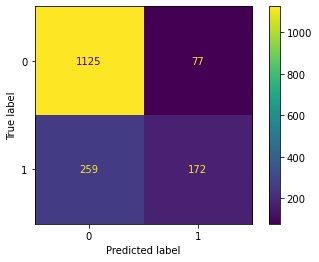



***********<class 'sklearn.ensemble._forest.RandomForestClassifier'>***********


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


Accuracy  0.8 F1:  0.51  Recall:  0.39  Precision:  0.73  MCC:  0.43


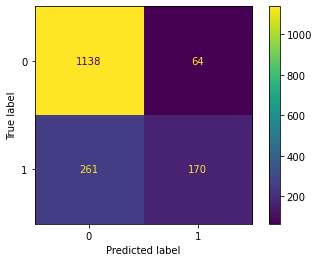

In [224]:
#Imbalanced training datasets 
LR_model = modeling(LogisticRegression, X_tr, X_val, y_tr, y_val,param={'random_state':1})
RF_model = modeling(RandomForestClassifier, X_tr, X_val, y_tr, y_val,param={'random_state':1})

In both cases, we get a higher accuracy and precision, while a bad F1 and recall. Confusion matrix, shows the high number of negative predictions that should actually be positive predictions (false negatives). 



***********<class 'sklearn.linear_model._logistic.LogisticRegression'>***********


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Accuracy  0.71 F1:  0.71  Recall:  0.72  Precision:  0.71  MCC:  0.42


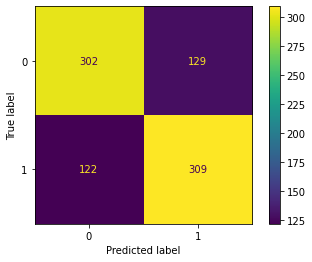



***********<class 'sklearn.ensemble._forest.RandomForestClassifier'>***********


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


Accuracy  0.73 F1:  0.74  Recall:  0.76  Precision:  0.71  MCC:  0.46


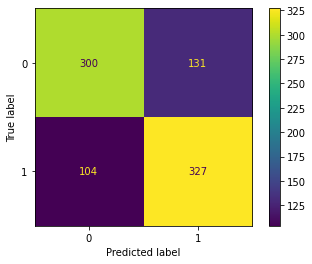

In [227]:
#Balanced training datasets 
LR_model_u = modeling(LogisticRegression, X_tr_u, X_val_u, y_tr_u, y_val_u, param={'random_state':1})
RF_model_u = modeling(RandomForestClassifier, X_tr_u, X_val_u, y_tr_u, y_val_u,param={'random_state':1})


We observe a higher recall and f1 when using the balanced train set, this observation is true in both ML algorithms, Logistic regression and Random forests. 





## Modeling observations 
A total of four tests were performed: 
    
    -Imbalanced dataset, logistic regression 
    Accuracy  0.79 F1:  0.51  Recall:  0.4  Precision:  0.69  MCC:  0.41
    -Imbalanced dataset, Random forests 
    Accuracy  0.8 F1:  0.51  Recall:  0.39  Precision:  0.73  MCC:  0.43
    -Balanced dataset, logistic regression 
    Accuracy  0.71 F1:  0.71  Recall:  0.72  Precision:  0.71  MCC:  0.42
    -Balanced dataset, Random forests 
    Accuracy  0.73 F1:  0.74  Recall:  0.76  Precision:  0.71  MCC:  0.46

I review some definitions about of the metrics just for reference: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

    -Accuracy=missleaading in the case of imbalanced datasets 
    
    -Precision=The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    
    -Recall=The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
    
    -F1 Score=The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)
    
    -MCC (Matthews Correlation Coefficient)=MMC is one of the most informative metric when binary classifications, ranges from -1 to 1; where -1 means total missclassification, 0 is no better than a random prediction and 1 is a perfect prediction. 
Ref of MCC for myself.  
https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html#sklearn.metrics.matthews_corrcoef

For the results using balanced and imbalaced datasets, the MCC is quite constant in the four tests performed, with a slight higher number of the Random Forest balanced dataset (0.46). It is important to mention that the number of samples in this dataset is in the order of thousands (8161 for the original imbalanced dataset), which was reduced to about half to obtain a balanced dataset (4306). In this case, I observe to options, either work with balanced dataset that has half the number of samples, or keep the imbalanced dataset with all of samples. 

I choose to keep an imbalanced dataset using RandomForests, for the only reason the MCC metric is not importantly more different (0.43 vs 0.46) while I can keep the most number of samples in a dataset that is not initially large (i.e. hundred of thousands of samples).  Perhaps if the number of samples was bigger I could have decided to keep the balanced dataset. 



## Tunning Parameters 

Finally, I just tun parameters for Random Forests using the imbalanced dataset 

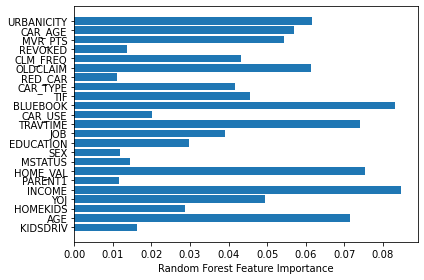

In [235]:
RF_model.feature_importances_
plt.barh(X_tr.columns, RF_model.feature_importances_)
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout()

Some of the parameters to tune in RF are: 

    max_depth; 
    n_estimators;  performance is not the goal and n_features=23, then 23**23 = 529
    min_samples_leaf
    max_features 



In [246]:

def best_param(model,x,y):
    search = GridSearchCV(estimator = model_, 
    param_grid = param_test1, scoring=Log_loss,n_jobs=-1, cv=4) ## cross validation

    
    
param_grid_RF = {'max_depth': [5, 25, 50],
             'n_estimators': [50, 250,500],
             'min_samples_leaf': [2, 5, 10],
             'max_features': ['sqrt','log2', 'auto']} 
search=GridSearchCV(RF_model,param_grid=param_grid_RF, scoring=)
search.fit(X_tr, y_tr)


C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\monic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [5, 25, 50],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [5, 25, 50, 100]})

# Predictions

In [ ]:
clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})